In [5]:
import numpy as np
import pandas as pd

train_path = "X_train.csv"
label_path = "y_train.csv"
test_path = "X_test.csv"
samples_path = "samples.csv"

df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
labeldf = pd.read_csv(label_path)


labels = labeldf.values
data = df.values
test_data = test_df.values

data = data[:,1:]
test_data = test_data[:,1:]
labels = labels[:,1]


print(data.shape)
print(test_data.shape)
print(labels.shape)



(5117, 17813)
(3411, 17813)
(5117,)


In [6]:
def count_instances(labels):
    unique, counts = np.unique(labels,return_counts=True)
    return dict(zip(unique,counts))

class_counts = count_instances(labels)

print("Class 0 Counts: {}".format(class_counts[0]))
print("Class 1 Counts: {}".format(class_counts[1]))
print("Class 2 Counts: {}".format(class_counts[2]))
print("Class 3 Counts: {}".format(class_counts[3]))


(num_train, max_timesteps) = data.shape
(num_test, _) = test_data.shape

Class 0 Counts: 3030
Class 1 Counts: 443
Class 2 Counts: 1474
Class 3 Counts: 170


In [7]:
def find_centerwave(templates):
    n_short = len(templates)
    dist_mat = np.zeros([n_short, n_short])
    for i in range(n_short):
        dist_mat[i, i] = 0.0
        for j in range(i+1, n_short):
            tmp_dist = dist(templates[i], templates[j])
            dist_mat[i, j] = tmp_dist
            dist_mat[j, i] = tmp_dist

    dist_mat_dist = np.sum(dist_mat, axis=1)
    centerwave = templates[np.argsort(dist_mat_dist)[0]]
    return centerwave

In [8]:
def dist(ts1, ts2):
    '''
    Input: two vectors
    Output: distance, numeric
    '''
    dist_num = np.linalg.norm(np.array(ts1) - np.array(ts2))
    return dist_num

In [33]:
def fftanalysis(signal, rate=300, first=8):
    try:
        fftsignal = np.abs(np.fft.fft(signal))**2
        if len(fftsignal < 8):
            fftsignal = np.append(fftsignal, np.zeros(first - len(fftsignal)))
    except Exception:
        fftsignal = np.zeros(first)
    # print(fftsignal)
    # freqs = np.fft.fftfreq(len(signal), d=1 / rate)
    # print(freqs)
    # plt.bar(freqs[:first], fftsignal[:first])
    # plt.show()
    return fftsignal[:first]

In [34]:
import sys
from biosppy.signals import tools as st
from biosppy.signals.ecg import correct_rpeaks, extract_heartbeats, hamilton_segmenter, ecg
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import argrelmax
from scipy.stats import stats

from scipy.stats import stats
from sklearn.metrics import f1_score
from biosppy import plotting, utils
          
    
def process_data(data, sampling_rate=300, show=False, verbose=True):
    x = []
    nanplaces = np.isnan(data)
    for i, signal in enumerate(data):
        stop_index = np.argmax(nanplaces[i,:]==True)-1
        temp = ecg(signal=signal[:stop_index],
                      sampling_rate=sampling_rate,
                      show=show
                      #segmenter=qrs_detector
                      )
        args = (data[i], temp["ts"], temp["filtered"], temp["rpeaks"],
                temp["templates_ts"], temp["templates"], temp["heart_rate_ts"],
                temp["heart_rate"])
        names = ('original', 'ts', 'filtered', 'rpeaks', 'templates_ts',
                 'templates', 'heart_rate_ts', 'heart_rate')
        temp = utils.ReturnTuple(args, names)
        x.append(temp)
        
        if verbose:
            if i % 300 == 0:
                print("Analysing sample ", i, "...Please wait...")
                sys.stdout.flush()
                
    return x

def signal_stats(signal):
    try:
        # mean, median, max, min, std, skewness, kurtosis
        # check inputs
        if signal is None:
            raise TypeError("Please specify an input signal.")

        # ensure numpy
        signal = np.array(signal)

        # mean
        mean = np.mean(signal)

        # median
        median = np.median(signal)

        # maximum amplitude abs
        maxAmpAbs = np.abs(signal - mean).max()

        # minimum amplitude abs
        minAmpAbs = np.abs(signal - mean).min()

        # maximum amplitude
        maxAmp = (signal - mean).max()

        # minimum amplitude
        minAmp = (signal - mean).min()

        # variance
        sigma2 = signal.var(ddof=1)

        # standard deviation
        sigma = signal.std(ddof=1)

        # absolute deviation
        ad = np.sum(np.abs(signal - median))

        # kurtosis
        kurt = stats.kurtosis(signal, bias=False)

        # skweness
        skew = stats.skew(signal, bias=False)
        
        # SNR
        snr = stats.signaltonoise(signal)
            
        # Entropy
        entropy = stats.entropy(signal)
        
        # Z-score
        
        zscore = stats.zscore(signal)
        
        # 3rd 4th, Moment
        
        mom3 = stats.moment(signal,3)
        mom4 = stats.moment(signal,4)
        
        # output
        args = (mean, median, maxAmpAbs, minAmpAbs, maxAmp, minAmp, sigma2,
                sigma, ad, kurt, skew )#, snr, entropy zscore, mom3, mom4)
        names = ('mean', 'median', 'maxabs', 'minabs', 'max', 'min', 'var',
                 'std_dev', 'abs_dev', 'kurtosis', 'skewness')#,"snr", "entropy")#"zscore","mom3","mom4")

        return utils.ReturnTuple(args, names)
    except Exception:
        args = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)#,0,0)#,0,0,0)
        names = ('mean', 'median', 'maxabs', 'minabs', 'max', 'min', 'var',
                 'std_dev', 'abs_dev', 'kurtosis', 'skewness')#,"snr", "entropy")#"zscore","mom3","mom4")

        return utils.ReturnTuple(args, names)
    
def RRIntervals(qrs_indices, sampling_rate=300):
    RR = np.diff(qrs_indices) / sampling_rate
    return RR

def extract_data(biooutput, sampling_rate=300):
    original_signal = biooutput["original"]
    filtered_signal = biooutput["filtered"]
    median_template = np.median(biooutput["templates"], axis=0)
    # plt.plot(median_template)
    mean_template = np.mean(biooutput["templates"], axis=0)
    std_template = np.std(biooutput["templates"], axis=0)

    # plt.plot(std_template)
    # plt.show()
    if len(median_template) == 0:
        median_template = np.zeros((0.6 * sampling_rate))
        mean_template = np.zeros((0.6 * sampling_rate))
        std_template = np.zeros((0.6 * sampling_rate))

    if len(biooutput["heart_rate"]) == 0:
        heart_rate = [0]
    else:
        heart_rate = biooutput["heart_rate"]

    if len(biooutput["rpeaks"]) == 0:
        rpeaks = [0]
    else:
        rpeaks = biooutput["rpeaks"]

    median_template_stats = signal_stats(median_template)
    mean_template_stats = signal_stats(mean_template)
    heartrate_stats = signal_stats(heart_rate)

    peak_values = original_signal[rpeaks]
    peak_stats = signal_stats(peak_values)

    rrintervals = RRIntervals(rpeaks)
    rrinterval_stats = signal_stats(rrintervals)

    median_temp_perc = np.percentile(median_template,
                                     [5, 15, 25, 35, 65, 75, 85, 95])
    mean_temp_perc = np.percentile(mean_template,
                                   [5, 15, 25, 35, 65, 75, 85, 95])
    heart_rate_perc = np.percentile(heart_rate,
                                    [5, 15, 25, 35, 65, 75, 85, 95])
    peak_perc = np.percentile(peak_values, [5, 15, 25, 35, 65, 75, 85, 95])

    rrinterval2 = np.diff(rrintervals)
    rrinterval2_stats = signal_stats(rrinterval2)
    
    rr50 = np.sum(rrinterval2 > 0.05)
    rr20 = np.sum(rrinterval2 > 0.02)
    prr50 = rr50 / len(rrinterval2)
    prr20 = rr20 / len(rrinterval2)
    hrv_data = np.array([rr50, rr20, prr50, prr20])

    numofpeaks = len(biooutput["rpeaks"])

    return (filtered_signal, median_template, mean_template, std_template,
            median_template_stats, mean_template_stats, heartrate_stats,
            peak_stats, rrinterval_stats, median_temp_perc, mean_temp_perc,
            heart_rate_perc, peak_perc, rrinterval2_stats, hrv_data,
            numofpeaks)


def featurevector(processed_signal, sampling_rate=300):
    results = extract_data(processed_signal, sampling_rate=sampling_rate)
    filtered_signal = results[0]
    median_template = results[1]
    mean_template = results[2]
    std_template = results[3]
    median_template_stats = list(results[4].as_dict().values())
    mean_template_stats = list(results[5].as_dict().values())
    heartrate_stats = list(results[6].as_dict().values())
    peak_stats = list(results[7].as_dict().values())
    rr_interval_stats = list(results[8].as_dict().values())
    median_temp_perc = results[9]
    mean_temp_perc = results[10]
    heart_rate_perc = results[11]
    peak_perc = results[12]
    rrinterval2_stats = list(results[13].as_dict().values())
    hrv_data = results[14]
    numofpeaks = results[14]
    centerwave = find_centerwave(processed_signal["templates"])
    fourier = fftanalysis(processed_signal["filtered"])
 
       
    features = np.array([])
    features = np.append(features, median_template)
    features = np.append(features, mean_template)
    features = np.append(features, std_template)
    features = np.append(features, median_template_stats)
    features = np.append(features, mean_template_stats)
    features = np.append(features, heartrate_stats)
    features = np.append(features, peak_stats)
    features = np.append(features, rr_interval_stats)
    features = np.append(features, median_temp_perc)
    features = np.append(features, mean_temp_perc)
    features = np.append(features, heart_rate_perc)
    features = np.append(features, peak_perc)
    features = np.append(features, rrinterval2_stats)
    features = np.append(features, hrv_data)
    features = np.append(features, numofpeaks)
    features = np.append(features, centerwave)
    features = np.append(features, fourier)

    return filtered_signal, features


In [35]:
X1 = data
X2 = np.array([])
processed = process_data(X1, sampling_rate=300, show=False, verbose=True)

_, temp = featurevector(processed[0], sampling_rate=300)
new_length = len(temp)
all_features = np.empty((X1.shape[0], new_length))
for i in range(X1.shape[0]):
        filtered_signal, features = featurevector(processed[i], sampling_rate=300)
        assert all_features.shape[1] == len(features)
        all_features[i, :] = features
        #print(filtered_signal.shape)
        
        #X1[i, :] = filtered_signal

        if i % 10 == 0:
            print("Extracting features from sample", i)
            sys.stdout.flush()

X2 = X2.reshape(X1.shape[0], -1)
X2 = np.hstack((X2, all_features))

Analysing sample  0 ...Please wait...
Analysing sample  300 ...Please wait...
Analysing sample  600 ...Please wait...
Analysing sample  900 ...Please wait...
Analysing sample  1200 ...Please wait...
Analysing sample  1500 ...Please wait...
Analysing sample  1800 ...Please wait...
Analysing sample  2100 ...Please wait...
Analysing sample  2400 ...Please wait...
Analysing sample  2700 ...Please wait...
Analysing sample  3000 ...Please wait...
Analysing sample  3300 ...Please wait...
Analysing sample  3600 ...Please wait...
Analysing sample  3900 ...Please wait...
Analysing sample  4200 ...Please wait...
Analysing sample  4500 ...Please wait...
Analysing sample  4800 ...Please wait...
Analysing sample  5100 ...Please wait...
Extracting features from sample 0
Extracting features from sample 10
Extracting features from sample 20
Extracting features from sample 30
Extracting features from sample 40
Extracting features from sample 50
Extracting features from sample 60
Extracting features from

/home/matthias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/matthias/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/matthias/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Extracting features from sample 640
Extracting features from sample 650
Extracting features from sample 660
Extracting features from sample 670
Extracting features from sample 680
Extracting features from sample 690
Extracting features from sample 700
Extracting features from sample 710
Extracting features from sample 720
Extracting features from sample 730
Extracting features from sample 740
Extracting features from sample 750
Extracting features from sample 760
Extracting features from sample 770
Extracting features from sample 780
Extracting features from sample 790
Extracting features from sample 800
Extracting features from sample 810
Extracting features from sample 820
Extracting features from sample 830
Extracting features from sample 840
Extracting features from sample 850
Extracting features from sample 860
Extracting features from sample 870
Extracting features from sample 880
Extracting features from sample 890
Extracting features from sample 900
Extracting features from sam

Extracting features from sample 2870
Extracting features from sample 2880
Extracting features from sample 2890
Extracting features from sample 2900
Extracting features from sample 2910
Extracting features from sample 2920
Extracting features from sample 2930
Extracting features from sample 2940
Extracting features from sample 2950
Extracting features from sample 2960
Extracting features from sample 2970
Extracting features from sample 2980
Extracting features from sample 2990
Extracting features from sample 3000
Extracting features from sample 3010
Extracting features from sample 3020
Extracting features from sample 3030
Extracting features from sample 3040
Extracting features from sample 3050
Extracting features from sample 3060
Extracting features from sample 3070
Extracting features from sample 3080
Extracting features from sample 3090
Extracting features from sample 3100
Extracting features from sample 3110
Extracting features from sample 3120
Extracting features from sample 3130
E

Extracting features from sample 5090
Extracting features from sample 5100
Extracting features from sample 5110


In [36]:
X1 = test_data
X_test = np.array([])
processed = process_data(X1, sampling_rate=300, show=False, verbose=True)

_, temp = featurevector(processed[0], sampling_rate=300)
new_length = len(temp)
all_features = np.empty((X1.shape[0], new_length))
for i in range(X1.shape[0]):
        filtered_signal, features = featurevector(processed[i], sampling_rate=300)
        assert all_features.shape[1] == len(features)
        all_features[i, :] = features
        #print(filtered_signal.shape)
        
        #X1[i, :] = filtered_signal

        if i % 300 == 0:
            print("Extracting features from sample", i)
            sys.stdout.flush()

X_test = X_test.reshape(X1.shape[0], -1)
X_test = np.hstack((X_test, all_features))

Analysing sample  0 ...Please wait...
Analysing sample  300 ...Please wait...
Analysing sample  600 ...Please wait...
Analysing sample  900 ...Please wait...
Analysing sample  1200 ...Please wait...
Analysing sample  1500 ...Please wait...
Analysing sample  1800 ...Please wait...
Analysing sample  2100 ...Please wait...
Analysing sample  2400 ...Please wait...
Analysing sample  2700 ...Please wait...
Analysing sample  3000 ...Please wait...
Analysing sample  3300 ...Please wait...
Extracting features from sample 0
Extracting features from sample 300
Extracting features from sample 600


/home/matthias/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/matthias/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/matthias/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)


Extracting features from sample 900
Extracting features from sample 1200
Extracting features from sample 1500
Extracting features from sample 1800
Extracting features from sample 2100
Extracting features from sample 2400
Extracting features from sample 2700
Extracting features from sample 3000
Extracting features from sample 3300


In [72]:
# One vs. All for class 3
# Gave lower validation score... (sadface)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

"""
X_2_3 = X2[np.argwhere(labels==3)]
X_2_rest = X2[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))]
labels_rest = labels[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))]

y_onevsall = np.zeros((X2.shape[0],1))
y_onevsall[np.argwhere(labels==3)] = 0
y_onevsall[np.argwhere(np.logical_or((labels==1) ,(labels==2) , (labels==0)))] = 1
y_onevsall = y_onevsall.reshape(X2.shape[0],)
"""
from sklearn.ensemble import RandomForestClassifier, VotingClassifier



rf =  RandomForestClassifier(n_estimators=30, criterion='gini',
                                        max_depth=3, min_samples_split=2, min_samples_leaf=5,
                                        min_weight_fraction_leaf=0.15, max_features='auto',
                                        max_leaf_nodes=5, min_impurity_decrease=0.0,
                                        min_impurity_split=None, bootstrap=True, oob_score=False,
                                        n_jobs=-1, random_state=None, verbose=0, warm_start=False,
                                        class_weight="balanced")#



sv= SVC(C=3.0, class_weight="balanced")


classifier1 = XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=20, verbosity=1,
                                        tree_method='auto',
                                        n_jobs=1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=6, base_score=0.5,
                                        random_state=0, missing=None)



classifier2 = XGBClassifier(max_depth=10, learning_rate=0.1, n_estimators=10, verbosity=1,
                                        tree_method='auto',
                                        n_jobs=1, gpu_id=0, gamma=0, min_child_weight=3,
                                        max_delta_step=0, subsample=1, colsample_bytree=1,
                                        colsample_bylevel=1, colsample_bynode=1, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=6, base_score=0.5,
                                        random_state=0, missing=None)


bmc_scorer = make_scorer(f1_score, average = 'micro')

vc = VotingClassifier(estimators=[('xgb',classifier1), ('xgb2', classifier2), ('rf', rf)], voting='hard')

tuned_parameters2 = [{'xgb__n_estimators':[20]}]

grid2 = GridSearchCV(vc,  param_grid=tuned_parameters2,  scoring=bmc_scorer, n_jobs=-1,cv =10, verbose=3)

In [73]:
#x_train, x_val, y_train, y_val = train_test_split(X_2_rest, labels_rest, test_size=0.25, random_state=0, stratify=labels)
x_train, x_val, y_train, y_val = train_test_split(X2, labels, test_size=0.25, random_state=0, stratify=labels)

from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(y_train),
                                             y_train))
w_array = np.ones(y_train.shape[0], dtype = 'float')
for i, val in enumerate(y_train):
    w_array[i] = class_weights[val-1]


grid2.fit(x_train,y_train)#,sample_weight=w_array)

y_pred = grid2.predict(x_val)
F1 = f1_score(y_val, y_pred, average='micro')
print("FINAL VALIDATION {}".format(F1))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.2min finished


FINAL VALIDATION 0.7546875


In [74]:
grid2.cv_results_

{'mean_fit_time': array([67.52]),
 'std_fit_time': array([12.4]),
 'mean_score_time': array([0.16]),
 'std_score_time': array([0.04]),
 'param_xgb__n_estimators': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'xgb__n_estimators': 20}],
 'split0_test_score': array([0.77]),
 'split1_test_score': array([0.78]),
 'split2_test_score': array([0.74]),
 'split3_test_score': array([0.75]),
 'split4_test_score': array([0.74]),
 'split5_test_score': array([0.76]),
 'split6_test_score': array([0.72]),
 'split7_test_score': array([0.76]),
 'split8_test_score': array([0.75]),
 'split9_test_score': array([0.73]),
 'mean_test_score': array([0.75]),
 'std_test_score': array([0.02]),
 'rank_test_score': array([1], dtype=int32)}

In [21]:
grid2.fit(X2,labels)
y_final = grid2.predict(X_test)
sample = pd.read_csv("sample.csv", delimiter=',')
sample['y'] = y_final
sample.to_csv("xgboost_featureSelection.csv", index = False)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.1min finished


In [68]:
grid2.cv_results_

{'mean_fit_time': array([220.39]),
 'std_fit_time': array([38.39]),
 'mean_score_time': array([0.16]),
 'std_score_time': array([0.03]),
 'param_xgb__n_estimators': masked_array(data=[66],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'xgb__n_estimators': 66}],
 'split0_test_score': array([0.79]),
 'split1_test_score': array([0.78]),
 'split2_test_score': array([0.74]),
 'split3_test_score': array([0.73]),
 'split4_test_score': array([0.75]),
 'split5_test_score': array([0.77]),
 'split6_test_score': array([0.74]),
 'split7_test_score': array([0.78]),
 'split8_test_score': array([0.76]),
 'split9_test_score': array([0.75]),
 'mean_test_score': array([0.76]),
 'std_test_score': array([0.02]),
 'rank_test_score': array([1], dtype=int32)}

Confusion matrix, without normalization
[[709   9  30  10]
 [ 11  75  25   0]
 [169  23 164  13]
 [ 15   4   5  18]]
Normalized confusion matrix
[[0.94 0.01 0.04 0.01]
 [0.1  0.68 0.23 0.  ]
 [0.46 0.06 0.44 0.04]
 [0.36 0.1  0.12 0.43]]


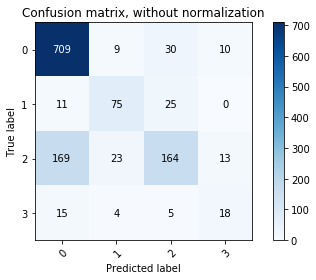

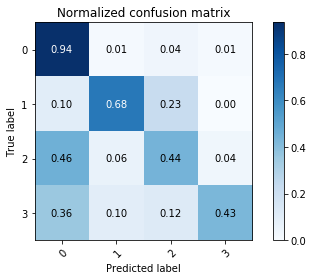

In [75]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



def plot_confusion_matrix(y_true, y_pred,normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_val, y_pred,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_val, y_pred, normalize=True,
                      title='Normalized confusion matrix')

plt.show()